# CHSH Detector Errors

This notebook investigates the CHSH violations with respect detector noise.
Detector noise is modeled by post-processing a noiseless pure state evolution of the parameterized CHSH ansatz circuit.
We consider two detector noise modes:
* **Error Flag Noise**: An error is flagged and output as $1$ with certainty.
* **White Noise**: An error is flagged and output as $0$ or $1$ with equal probability.

We find the Error Flag Noise resembles amplitude damping on the individual qubits while detector white noise resembles depolarizing noise on the qubits.

In [17]:
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from context import qnetvo as qnet

In [3]:
def RY_CNOT(settings, wires):
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])
    qml.CNOT(wires=wires[0:2])

bell_prep_nodes = [
    qnet.PrepareNode(1, [0, 1], RY_CNOT, 2),
]
arb_prep_nodes = [
    qnet.PrepareNode(1, [0, 1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

RY_meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qnet.local_RY, 1),
    qnet.MeasureNode(2, 2, [1], qnet.local_RY, 1),
]

arb_meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    qnet.MeasureNode(2, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]

## Cost Function for CHSH Inequality with Detector Errors

In [22]:
chsh_ansatz = qnet.NetworkAnsatz(bell_prep_nodes, RY_meas_nodes)

@qml.qnode(chsh_ansatz.dev)
def chsh_probs(settings):
    chsh_ansatz.fn(settings)
    
    return qml.probs(chsh_ansatz.measure_wires)

def detection_error_chsh_cost(scenario_settings, error_map, error_rates):
    
    pe1, pe2 = error_rates
    
    # errors our output as 1 value
    detector_error_map1 = np.eye(2) * (1 - pe1)
    detector_error_map1 += error_map * pe1
    
    detector_error_map2 = np.eye(2) * (1 - pe2)
    detector_error_map2 += error_map * pe2
    
    chsh_detector_errors = np.kron(detector_error_map1, detector_error_map2)
    
    chsh_score = 0
    
    for x, y in [[0,0],[0,1],[1,0],[1,1]]:
        
        probs = chsh_probs(chsh_ansatz.qnode_settings(scenario_settings, [0], [x,y]))  
        post_probs = chsh_detector_errors @ probs
        correlator = np.sum(post_probs * np.array([1,-1,-1,1]))
        
        chsh_score += (-1)**(x * y) * correlator
        
    
    return -(chsh_score)    

## Main Function for Scanning Through Detector Error Rates

In [25]:
params_range = np.arange(0,1.01,0.1)
params_range.requires_grad=False

def scan_detector_error_rates(prep_nodes, meas_nodes, error_map, scan_range):
    
    opt_violations = np.zeros((11,11))
    noiseless_violations = np.zeros((11,11))
    
    depolarized_distances = np.zeros((11,11))
    noiseless_depolarized_distances = np.zeros((11,11))
    
    classical_distances = np.zeros((11,11))
    noiseless_classical_distances = np.zeros((11,11))
    
    p1_scan_params, p2_scan_params = np.meshgrid(scan_range,scan_range)
      
    chsh_ansatz = qnet.NetworkAnsatz(prep_nodes, meas_nodes)
    ideal_chsh_cost = lambda scenario_settings: detection_error_chsh_cost(scenario_settings, np.eye(2), [0,0])
    
    for i in range(11):
        for j in range(11):
            error_rates = [p1_scan_params[i,j],p2_scan_params[i,j]]
            
            chsh_cost = lambda scenario_settings: detection_error_chsh_cost(scenario_settings, error_map, error_rates)

            print("Detector Error Rates : ", error_rates)

            @qml.qnode(chsh_ansatz.dev)
            def state(prep_settings):
                chsh_ansatz.circuit_layer(chsh_ansatz.prepare_nodes)(prep_settings)

                return qml.state()

            init_settings = chsh_ansatz.rand_scenario_settings()

            opt_dict = qnet.gradient_descent(
                chsh_cost,
                init_settings,
                num_steps = 55,
                step_size = 0.5,
                sample_width = 5,
                verbose=False
            )    
            
            opt_violations[i,j] = opt_dict["opt_score"]
            noiseless_violations[i,j] = -(ideal_chsh_cost(opt_dict["opt_settings"]))
    
    return (
        opt_violations,
        noiseless_violations,
    )

## Error Flag Noise

In [27]:
%%time

(
    flag_violations,
    flag_noiseless_violations,
) = scan_detector_error_rates(
    bell_prep_nodes,
    RY_meas_nodes,
    np.array([[0,0],[1,1]]),
    params_range
)

Detector Error Rates :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(1., requires_grad=False), tensor(0., requires_gra

Detector Error Rates :  [tensor(0.1, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(1., requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0., requires_grad=False), tensor(0.9, r

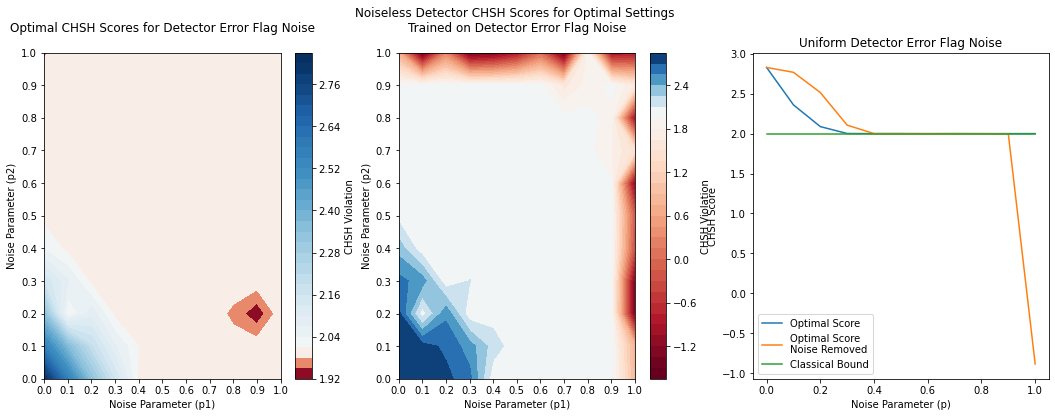

In [34]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=flag_violations.min(), vmax = flag_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=flag_noiseless_violations.min(),
    vmax = flag_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, flag_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Detector Error Flag Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, flag_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless Detector CHSH Scores for Optimal Settings \nTrained on Detector Error Flag Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

flag_uniform_scores = [flag_violations[i,i] for i in range(11)]
flag_noiseless_uniform_scores = [flag_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), flag_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), flag_noiseless_uniform_scores, label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Detector Error Flag Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

## White Noise Detector Error

In [30]:
%%time

(
    white_violations,
    white_noiseless_violations,
) = scan_detector_error_rates(
    bell_prep_nodes,
    RY_meas_nodes,
    np.array([[0.5,0.5],[0.5,0.5]]),
    params_range
)

Detector Error Rates :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Detector Error Rates :  [tensor(1., requires_grad=False), tensor(0., requires_gra

Detector Error Rates :  [tensor(0.1, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(1., requires_grad=False), tensor(0.8, requires_grad=False)]
Detector Error Rates :  [tensor(0., requires_grad=False), tensor(0.9, r

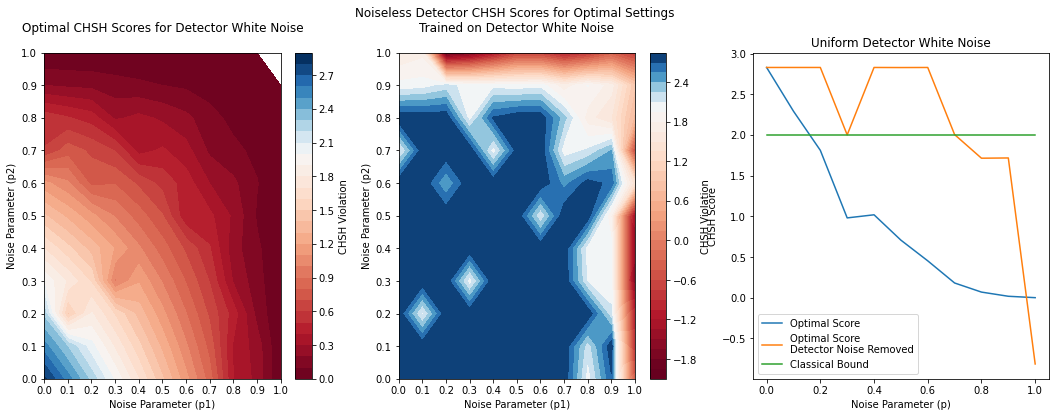

In [35]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=white_violations.min(), vmax = white_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=white_noiseless_violations.min(),
    vmax = white_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, white_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Detector White Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, white_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless Detector CHSH Scores for Optimal Settings \nTrained on Detector White Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

white_uniform_scores = [white_violations[i,i] for i in range(11)]
white_noiseless_uniform_scores = [white_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), white_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), white_noiseless_uniform_scores, label="Optimal Score\nDetector Noise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Detector White Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

In [10]:
9/16

0.5625